In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests # For API requests
import json # For API requests
import time # To delay API & web scrapping pulls to avoid crashes
from tqdm import tqdm #to see progres of loop

from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy import stats

pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', 100)

## Importing and Preprocessing

In [4]:
# read in the df
links = pd.read_csv('./movielens_data/links.csv')
movies = pd.read_csv('./movielens_data/movies.csv')
ratings = pd.read_csv('./movielens_data/ratings.csv')
tags = pd.read_csv('./movielens_data/tags.csv')

In [5]:
df_ratings = ratings.drop('timestamp', axis=1)

In [6]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

In [7]:
genre_count = pd.DataFrame(keyword_occurences, columns = ['genre', 'count'])
genre_count = pd.DataFrame(keyword_occurences, columns = ['genre', 'count'], index = genre_count.genre)

In [8]:
genre_count.head()

,genre,count
genre,,
Drama,Drama,4361
Comedy,Comedy,3756
Thriller,Thriller,1894
Action,Action,1828
Romance,Romance,1596


<Figure size 432x288 with 0 Axes>

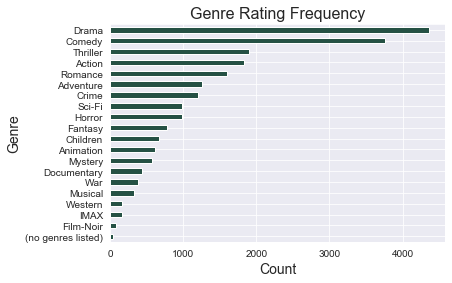

In [9]:
fig, ax = plt.subplots(0)
sns.set_style('darkgrid')
ax = genre_count.sort_values(by='count').plot(kind='barh', legend=False, color='#255144')
ax.set_ylabel('Genre',fontsize=14)
ax.set_xlabel('Count', fontsize=14)
ax.set_title('Genre Rating Frequency', fontsize=16)
plt.savefig('./movielens_data/genre_rating_freq.png', dpi=200)
plt.show()

In [19]:
ratings_count = ratings['rating'].value_counts().sort_index(ascending=False)
type(ratings_values)

pandas.core.series.Series

AttributeError: 'Series' object has no attribute 'rating'

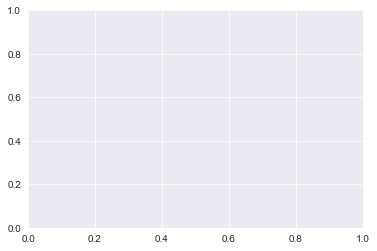

In [16]:
fig, ax = plt.subplots()
sns.set_style('darkgrid')
ax = ratings_values.rating.plot(kind="bar", color='#e4892e')
ax.set_ylabel('Frequency [count]',fontsize=14 )
ax.set_xlabel('Ratings', fontsize=14)
ax.set_title('Ratings', fontsize=16)
plt.savefig('./movielens_data/ratings_freq.png', dpi=200)
plt.show()

In [ ]:
ratings.rating.describe()

In [ ]:
ratings.rating.mode()

In [ ]:
mv_ratings = ratings.merge(movies, on='movieId', how = 'inner')
mv_ratings.drop(columns=['title', 'genres', 'timestamp'], inplace = True)

In [ ]:
imdb = links['imdbId'].values.astype(str)

In [ ]:
def correct_imdb_ids(imdb):  
    imdb_ids = []
    for ids in imdb:
        if len(ids) == 3:
            imdb_ids.append('tt0000'+ids)
        elif len(ids) == 4:
            imdb_ids.append('tt000'+ids)
        elif len(ids) == 5:
            imdb_ids.append('tt00'+ids)
        elif len(ids) == 6:
            imdb_ids.append('tt0'+ids)
        elif len(ids) == 7:
            imdb_ids.append('tt'+ids)   
    return imdb_ids    #created function to correct the format of the IMDB ID's (need in order to do correct API pull)

In [ ]:
imdb_ids = correct_imdb_ids(imdb)  #tested function to see if it worked properly
imdb_ids[:5]

In [ ]:
len(imdb_ids)

In [ ]:
api_key = '49fc59a029e4df5ad29e6be556dae829'

In [ ]:
# source imdb data for rated movies.
#imdb_data = []
#for ids in tqdm(imdb_ids):
#    request = requests.get('https://api.themoviedb.org/3/movie/' + ids + '?api_key=' + api_key + '&language=en-US')
#    time.sleep(.200)
#    i = request.json()
#    imdb_data.append(i)
#print(imdb_data)

In [ ]:
total_mdb = pd.read_csv('./movielens_data/total_mdb')
total_mdb.head()

In [ ]:
# merge movies and links data
links['imdb_id'] = imdb_ids

In [ ]:
mv_ratings = ratings.merge(movies, on = 'movieId', how ='inner')  #merging the movie and rating Data Frames
mv_ratings.drop(columns=['timestamp','genres'], inplace = True)

In [ ]:
mv_ratings.head();

In [ ]:
# now merge imdb link list with mv_ratings df
links_mv_df = mv_ratings.merge(links, on = 'movieId', how ='inner') 
links_mv_df.drop(columns=['tmdbId','imdbId'], inplace = True)
links_mv_df.head()

In [ ]:
#now final merge with API data -> merge API data with rating data on IMDB ID
complete_df = links_mv_df.merge(total_mdb, on = 'imdb_id', how ='inner')  

#drop extraneous columns
complete_df.drop(columns=['homepage','tagline','backdrop_path','belongs_to_collection', 'original_language','vote_count','status_message',
               'poster_path','adult','id','original_title', 'production_companies', 'production_countries','status_code',
               'overview','spoken_languages','status','title_y','video','vote_average','success'], inplace = True)

In [ ]:
# verify new df
complete_df.head();

In [ ]:
# verify dtypes in complete df
complete_df.dtypes

### Hypothesis Testing

Because this recommendation system is issuing predictions based on predicted ratings, it seemed pertinent to explore the relationship between ratings issued  and other factors in order to contextualize the recommender.

In [ ]:
stats.f_oneway(complete_df['budget'][complete_df['rating'] == 0.5],
               complete_df['budget'][complete_df['rating'] == 1.0],
               complete_df['budget'][complete_df['rating'] == 1.5],
               complete_df['budget'][complete_df['rating'] == 2.0],
               complete_df['budget'][complete_df['rating'] == 2.5],
               complete_df['budget'][complete_df['rating'] == 3.0],
               complete_df['budget'][complete_df['rating'] == 3.5],
               complete_df['budget'][complete_df['rating'] == 4.0],
               complete_df['budget'][complete_df['rating'] == 4.5],
               complete_df['budget'][complete_df['rating'] == 5.0])

H_0: There is no statistically significant difference between the budget of a movie and its movie rating.

H_A: There is not a statistically significant difference between the budget of a movie and its movie rating

Result:

**p << alpha=0.05 : we reject the null hypothesis and conclude there is a statistically significant difference between ratings across production budgets**

In [ ]:
x = complete_df.groupby('rating')['budget'].median().sort_values(ascending = False).keys()
y = complete_df.groupby('rating')['budget'].median().sort_values(ascending = False).values
sns.set_style('darkgrid')
fig,ax=plt.subplots(figsize=(15,10))

sns.barplot(x, y, order = complete_df.groupby('rating')['budget'].median().sort_values(ascending = False).keys(),
           color = '#c33d1d')
ax.set_xlabel('Movie Rating',fontweight='bold', fontsize=(15))
ax.set_ylabel('Budget ($) Tens of Million', fontweight='bold', fontsize=(15))
ax.set_title('Average Budget by Movie Rating', fontweight='bold', fontsize=(20))

#### Add a hypothesis test

In [229]:
new_df = pd.DataFrame(df.groupby('title')['rating'].mean())
new_df['Total_Ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
new_df.rename(columns = {'rating':'Avg_Rating'}, inplace = True)
new_df.head()

,Avg_Rating,Total_Ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [230]:
movie_user = df.pivot_table(index='userId',columns='title',values='rating')
movie_user

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [231]:
Ratings = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building the Models

We chose to use two models to address two approaches in collaborative filtering recommendation engines. These models are KNN which is a Neigborhood-Based method of filtering (making automatic predictions) and SVD which is a model based method. 

**KNN:** 
    KNN is a machine learning algorithm to find clusters of similar users (neighbors) based on common movie ratings, and make predictions using the average rating of top-k nearest neighbors. It uses the weighted-average of the k-most similar neighbors to issue a predicted rating.

**SVD:** 
    SVD is another machine learning algorithm that tries to explain complex relationships between variables in a dataset by decomposing the dataset or matrix and centering on latent relationships much like PCA.
    It is found to be the most accurate approach to reduce problems with sparsity in the data as all users do not rate all movies leading to sparsity in the data. Another useful feature is that SVDs create embeddings (analogous to principle component loadings) which are low-dimensional hidden factors which for a certain user and item coupling can represent exogenous features of the data like how political a movie is, how much special effects it contained and perhaps how dialogue driven the movie is.
    
    
**Evaluation Metrics:**

   For our chosen models we primarily focused on RMSE as an evaluation metric since we want to evaluate how good our model predicts ratings a given user and movie. A lower RMSE is indicative of improved performance across model runs.

We focus on RMSE over MAE as our evaluation metric because RMSE penalizes larger errors more than MAE. They are both indifferent to the direction of errors and they are negatively oriented which means lower scores are better.

**KNN vs SVD:**

| KNN                                 | SVD                                                  |
|-------------------------------------|------------------------------------------------------|
| Complete input data is required     |Creates an abstraction that represents data (like PCs)|
| Does not scale well                 |Scales well|
| Pre-computation not possible        |pre-computation possible|
|Relies on user-itemsimilarity metrics|Relies on matrix factorization|

In [232]:
from surprise import Reader, Dataset
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import BaselineOnly
from surprise.model_selection import train_test_split
from surprise import accuracy

In [233]:
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)

In [234]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [235]:
# train-test-split
trainset, testset = train_test_split(data, test_size=.25)

#### Baseline Model

In [236]:
algorithm = BaselineOnly()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
bl_rmse = accuracy.rmse(predictions)
bl_mae = accuracy.mae(predictions)

Estimating biases using als...
RMSE: 0.8772
MAE:  0.6771


#### KNN Basic

In [237]:
algorithm = KNNBasic()
algorithm.fit(trainset)
predictions = algorithm.test(testset)
# check the accuracy using Root Mean Square Error
knnbasic_rmse = accuracy.rmse(predictions)
knnbasic_mae = accuracy.mae(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9544
MAE:  0.7311


#### KNN Baseline

In [238]:
algorithm = KNNBaseline()
algorithm.fit(trainset)
predictions = algorithm.test(testset)
# check the accuracy using Root Mean Square Error
knnbaseline_rmse = accuracy.rmse(predictions)
knnbaseline_mae = accuracy.mae(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8828
MAE:  0.6751


Why KNN and is this a good evaluation? 
What are its pros and cons?
Answer: ...

#### SVD GridSearchCV

In [300]:
# params = {'n_factors': [20, 50, 100, 130],
#          'reg_all': [0.02, 0.05, 0.1],
#           "n_epochs": [15, 20, 30]}
# g_s_svd = GridSearchCV(SVD ,param_grid=params, n_jobs=-1)
# g_s_svd.fit(data)

KeyboardInterrupt: 

In [ ]:
# print(g_s_svd.best_score)
# print(g_s_svd.best_params)

#### SVD

In [241]:
algorithm = SVD(n_factors= 130, reg_all=0.05, n_epochs=30)
algorithm.fit(trainset)
predictions = algorithm.test(testset)
# check the accuracy using Root Mean Square Error
svd_rmse = accuracy.rmse(predictions)
svd_mae = accuracy.mae(predictions)

RMSE: 0.8695
MAE:  0.6681


Why SVD and is this a good evaluation? 
Answer: ...

#### KNN_Basic CV (Pearson)

In [242]:
knn_basic_P = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic_P = cross_validate(knn_basic, data, n_jobs=-1)
knn_basic_cv_p_rmse = np.mean(cv_knn_basic_P['test_rmse'])
knn_basic_cv_p_mae = np.mean(cv_knn_basic_P['test_mae'])
print('RMSE: ', knn_basic_cv_p_rmse)
print('MAE: ', knn_basic_cv_p_mae)

RMSE:  0.9728360686525763
MAE:  0.7513501058991361


#### KNN_Basic CV (Cosine)

In [243]:
knn_basic_C = KNNBasic(sim_options={'name':'cosine', 'user_based':True})
cv_knn_basic_C = cross_validate(knn_basic, data, n_jobs=-1)
knn_basic_cv_c_rmse = np.mean(cv_knn_basic_C['test_rmse'])
knn_basic_cv_c_mae = np.mean(cv_knn_basic_C['test_mae'])
print('RMSE: ', knn_basic_cv_c_rmse)
print('MAE: ', knn_basic_cv_c_mae)

RMSE:  0.9718885302635412
MAE:  0.7508022604494755


#### KNN_Baseline CV (Pearson)

In [244]:
knn_baseline_P = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline_P = cross_validate(knn_baseline,data)
knn_baseline_cv_p_rmse = np.mean(cv_knn_baseline_P['test_rmse'])
knn_baseline_cv_p_mae = np.mean(cv_knn_baseline_P['test_mae'])
print('RMSE: ', knn_baseline_cv_p_rmse)
print('MAE: ', knn_baseline_cv_p_mae)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE:  0.8779816042274371
MAE:  0.6702252396133784


#### KNN_Baseline CV (Cosine)

In [245]:
knn_baseline_C = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline_C = cross_validate(knn_baseline,data)
knn_baseline_cv_c_rmse = np.mean(cv_knn_baseline_C['test_rmse'])
knn_baseline_cv_c_mae = np.mean(cv_knn_baseline_C['test_mae'])
print('RMSE: ', knn_baseline_cv_c_rmse)
print('MAE: ', knn_baseline_cv_c_mae)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE:  0.878065100284436
MAE:  0.6705426863284076


### Final Table

In [246]:
scores = {}
scores['KNN_Baseline'] = knnbaseline_rmse, knnbaseline_mae
scores['KNN_Baseline_CV_P'] = knn_baseline_cv_p_rmse, knn_baseline_cv_p_mae
scores['KNN_Baseline_CV_C'] = knn_baseline_cv_c_rmse, knn_baseline_cv_c_mae
scores['KNN_Basic'] = knnbasic_rmse, knnbasic_mae
scores['KNN_Basic_CV_P'] = knn_basic_cv_p_rmse, knn_basic_cv_p_mae
scores['KNN_Basic_CV_C'] = knn_basic_cv_c_rmse, knn_basic_cv_c_mae
scores['Baseline'] = bl_rmse, bl_mae
scores['SVD'] = svd_rmse, svd_mae
scores

{'KNN_Baseline': (0.8828353434805751, 0.6750667479313054),
 'KNN_Baseline_CV_P': (0.8779816042274371, 0.6702252396133784),
 'KNN_Baseline_CV_C': (0.878065100284436, 0.6705426863284076),
 'KNN_Basic': (0.9543606440517752, 0.7311338050984176),
 'KNN_Basic_CV_P': (0.9728360686525763, 0.7513501058991361),
 'KNN_Basic_CV_C': (0.9718885302635412, 0.7508022604494755),
 'Baseline': (0.8771910004364397, 0.6771103721849699),
 'SVD': (0.8694720197904461, 0.6680529608381369)}

In [247]:
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE', 'MAE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

,RMSE,MAE
Models,,
SVD,0.869472,0.668053
Baseline,0.877191,0.677110
KNN_Baseline_CV_P,0.877982,0.670225
KNN_Baseline_CV_C,0.878065,0.670543
KNN_Baseline,0.882835,0.675067
KNN_Basic,0.954361,0.731134
KNN_Basic_CV_C,0.971889,0.750802
KNN_Basic_CV_P,0.972836,0.751350


Why we chose RMSE instead of MAE?


Interpret results and explain again SVD with RMSE

## Build Recommendation System

In [249]:
svd = SVD(n_factors= 130, reg_all=0.05, n_epochs=30)
svd.fit(dataset)

In [250]:
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=2.8218859265431417, details={'was_impossible': False})

### Rec's for a new user

In [290]:
user_rating = [{'userId': 700, 'movieId': 1, 'rating': '4'},
 {'userId': 700, 'movieId': 107, 'rating': '5'},
 {'userId': 700, 'movieId': 231, 'rating': '5'},
 {'userId': 700, 'movieId': 2986, 'rating': '3.5'}]

### Making Predictions with New Rating

In [291]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = ratings_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [292]:
# train a model using the new combined DataFrame
svd_ = SVD(n_factors= 130, reg_all=0.05, n_epochs=30)
svd_.fit(new_data.build_full_trainset())

In [293]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
list_of_movies = []
for m_id in ratings_df['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(700,m_id)[3]))

In [294]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [295]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies_df,5)

Recommendation #  1 :  2593    Hustler, The (1961)
Name: title, dtype: object 

Recommendation #  2 :  709    Rebecca (1940)
Name: title, dtype: object 

Recommendation #  3 :  3141    Memento (2000)
Name: title, dtype: object 

Recommendation #  4 :  714    To Catch a Thief (1955)
Name: title, dtype: object 

Recommendation #  5 :  924    Grand Day Out with Wallace and Gromit, A (1989)
Name: title, dtype: object 



UserId 700 aka JP's emperical evaluation:
... 